In [378]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import solve_ivp
from scipy.constants import N_A
import math

In [413]:
Target_cell_number = 2e5
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
synapse_gap = 25e-9
synapse_width = 10e-6
r_ab = 1.25e-8
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)
tumour_cell_IS_proportion = (synapse_width**2)/(tumour_cell_surface_area)
NK_cell_radius = 3.25e-6
NK_cell_surface_area = 4*math.pi*((NK_cell_radius)**2)
NK_cell_IS_proportion = (synapse_width**2)/NK_cell_surface_area
assay_to_synapse_conversion = (synapse_width**2*synapse_gap)/well_size
sigma_synapse = sigma*assay_to_synapse_conversion
reaction_volume1 = (2*math.pi*(r_ab**3))/3
reaction_volume2 = (2/3)*math.pi*((0.5*r_ab)**3)
reaction_volume3 = (2/3)*math.pi*((2*r_ab)**3)
reaction_volume_4 = (1/3)*math.pi*((r_ab)**3)

t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 50)
tspan = [1e-10, t_end]
print(tumour_cell_IS_proportion)
#A00 initial assumed to be 0 because of size exclusion in synapse

0.12433979929054326


In [380]:
def R_single_cell(t, z, Ainit, rtot, kon, k2, koff):
     
     k = kon/sigma
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0) - koff*z[0] - (k2*Ag*z[0]/rtot) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]/rtot) - 2*koff*z[1]

     return [dA10, dA11]

def S_single_cell(t, z, Ainit, rtot, kon, k2, koff):
     
     k = kon/sigma
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z[0] - z[1] 
     Ag = rtot - z[0] - 2*z[1]

     dA10 = 2*(k*Ag*A0) - koff*z[0] - (k2*Ag*z[0]) + 2*koff*z[1]
     dA11 = (k2*Ag*z[0]) - 2*koff*z[1]

     return [dA10, dA11]

In [402]:
def R_two_cells(t, z, k1, k2, k3, k4, k5, k6, k7, k1off, k2off, rtot, rtot_fc, Atot):


    A0 = (Atot - (z[0] + z[1] + z[3] + z[4] + z[2]))
    rt = rtot- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc - z[2] - (z[3] + z[4])
    
    dA10 = 2*k1*(A0)*(rt) - k1off*z[0] - k2*z[0]*(rt/rtot) + 2*k1off*z[1] - k4*z[0]*(rf/rtot_fc) + k2off*z[3]
    dA20 = k2*z[0]*(rt/rtot) - 2*k1off*z[1] - k5*z[1]*(rf/rtot_fc) + k2off*z[4]
    dA01 = k3*(A0)*(rf) - k2off*z[2] - 2*k6*z[2]*(rt/rtot) + k1off*z[3]
    dA11 = k4*z[0]*(rf/rtot_fc) - k2off*z[3] + 2*k6*z[2]*(rt/rtot) -k1off*z[3] - k7*z[3]*(rt/rtot) + 2*k1off*z[4]
    dA21 = k5*z[1]*(rf/rtot_fc) - k2off*z[4] + k7*z[3]*(rt/rtot) - 2*k2off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

def S_two_cells(t, z, k1, k2, k3, k4, k1off, k2off, rtot_synapse, rtot_fc_synapse, Atot):


    A0 = (Atot - (z[0] + z[1] + z[3] + z[4] + z[2]))
    rt = rtot_synapse- z[0] - z[3] - 2*(z[1] + z[4])
    rf = rtot_fc_synapse - z[2] - (z[3] + z[4])
    
    dA10 = 2*k1*(A0)*(rt) - k1off*z[0] - k2*z[0]*(rt) + 2*k1off*z[1] - k4*z[0]*(rf) + k2off*z[3]
    dA20 = k2*z[0]*(rt) - 2*k1off*z[1] - k4*z[1]*(rf) + k2off*z[4]
    dA01 = k3*(A0)*(rf) - k2off*z[2] - 2*k2*z[2]*(rt) + k1off*z[3]
    dA11 = k4*z[0]*(rf) - k2off*z[3] + 2*k2*z[2]*(rt) -k1off*z[3] - k2*z[3]*(rt) + 2*k1off*z[4]
    dA21 = k4*z[1]*(rf) - k2off*z[4] + k2*z[3]*(rt) - 2*k2off*z[4]
    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [382]:
def two_cells_dimensionless(t, z, alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, alpha7, gamma2, gamma3, gamma4, gamma5, gamma6, gamma7, beta, phi):

    A00 = 1- (1/beta)*(z[0] + z[1] + z[3] + z[4]) + (z[2]/(beta*phi))
    rt = 1 - z[0] - z[1] - 2*(z[3] + z[4])
    rf = 1 - z[2] + phi*(z[3] + z[4])

    dA10 = 2*alpha1*beta*A00*rt - z[0] - alpha2*z[0] + gamma2*z[1] - alpha4*z[0]*rf + gamma4*z[3]
    dA20 = alpha2*z[0]*rt - gamma2*z[1] - alpha5*z[1]*rf + gamma5*z[4]
    dA01 = alpha3*beta*phi*A00*rf - gamma3*z[2] - 2*alpha6*z[2]*rt + gamma6*phi*z[3]
    dA11 = alpha4*z[0]*rf - gamma4*z[3] + (2*alpha6/phi)*z[2] - gamma6*z[3] -alpha7*z[3]*rt + gamma7*z[4]
    dA21 = alpha5*z[1]*rf - gamma5*z[4] + alpha7*z[3]*rt - gamma7*z[4]

    dz = [dA10, dA20, dA01, dA11, dA21]

    return dz

In [383]:
kon = 1e5
qon = 6.5e3
koff = 1e-4
qoff = 4.7e-3
rtot = 1e5
rtot_fc = 2.2e5
rtot_synapse = rtot*tumour_cell_IS_proportion
rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion

k1 = kon/sigma_synapse
k3 = qon/sigma_synapse

target_effective_conc1 =(rtot_synapse)*(synapse_width**2)*(1/N_A)/(reaction_volume1)
k2 = target_effective_conc1*kon

target_effective_conc2 = (rtot_fc_synapse)*(synapse_width)*(1/N_A)/(reaction_volume3)
k4 = target_effective_conc2*qon

target_effective_conc3 = (rtot_fc_synapse)*(synapse_width)*(1/N_A)/(reaction_volume1)
k5 = target_effective_conc3*qon

target_effective_conc4 = (rtot_synapse)*(synapse_width)*(1/N_A)/(reaction_volume3)
k6 = target_effective_conc2*kon

target_effective_conc5 = (rtot_synapse)*(synapse_width)*(1/N_A)/(reaction_volume_4)
k7 = target_effective_conc5*kon
print((k4/rtot_fc_synapse)/((k2/rtot_synapse)*(k5/rtot_fc_synapse)))

30792.827425943444


2.214052089565129e-10 3.264752649189157e-05


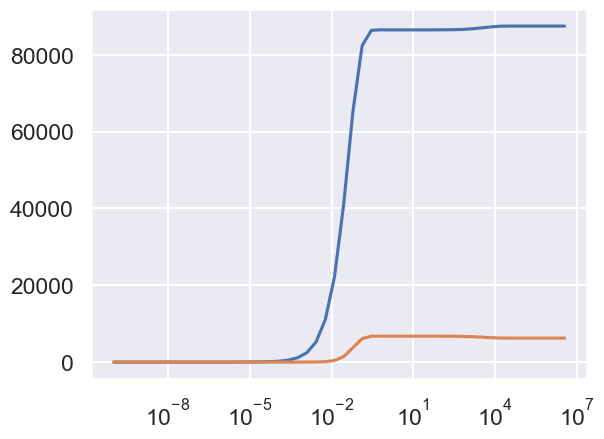

In [384]:
Ainit = 1e-4
target_effective_conc =(rtot)*(tumour_cell_surface_area)*(1/N_A)/(reaction_volume1)

k2_single = target_effective_conc*kon
z0 = [0, 0]
print(kon/sigma, k2_single/rtot)
z = solve_ivp(R_single_cell, tspan, z0, method='BDF', t_eval=t, args=(Ainit, rtot, kon, k2_single, koff))

A1 = z.y[0]
A2 = z.y[1]

plt.plot(t, A1, label = r'$A_{10}$')
plt.plot(t, A2, label = r'$A_{20}$')
plt.xscale('log')
A10_IC = A1[-1]*tumour_cell_IS_proportion
A20_IC = A2[-1]*tumour_cell_IS_proportion
Atot = A10_IC + A20_IC 
z0 = [A10_IC, A20_IC, 0, 0, 0]
z = solve_ivp(R_two_cells, tspan, z0, method='BDF', t_eval=t, args=(k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))

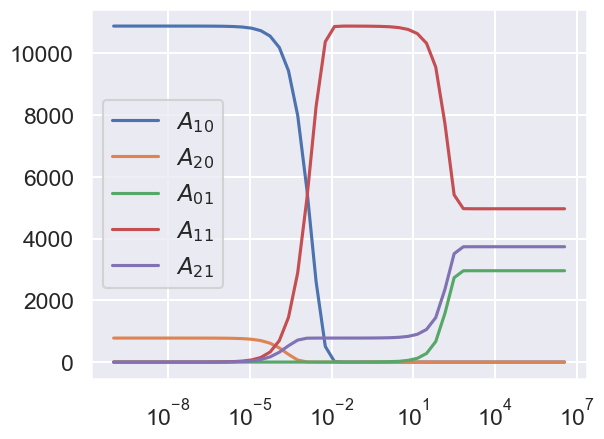

In [385]:
sns.set_theme()
sns.set_context('talk')

A10 = z.y[0]
A20 = z.y[1]
A01 = z.y[2]
A11 = z.y[3]
A21 = z.y[4]

plt.plot(t, A10, label = r'$A_{10}$')
plt.plot(t, A20, label = r'$A_{20}$')
plt.plot(t, A01, label = r'$A_{01}$')
plt.plot(t, A11, label = r'$A_{11}$')
plt.plot(t, A21, label = r'$A_{21}$')


plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [441]:
t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 500)
tspan = [1e-10, t_end]
A0s = np.geomspace(1e-12, 1e-4, 25)
A10rs = np.zeros_like(A0s)
A20rs = np.zeros_like(A0s)
A01rs = np.zeros_like(A0s)
A11rs = np.zeros_like(A0s)
A21rs = np.zeros_like(A0s)

for i, Ainit in enumerate(A0s):
    print(i)
    z0 = [0, 0]
    z = solve_ivp(R_single_cell, tspan, z0, method='BDF', t_eval=t, args=(Ainit, rtot, kon, k2_single, koff))

    A1 = z.y[0]
    A2 = z.y[1]

    A10_IC = A1[-1]*tumour_cell_IS_proportion
    A20_IC = A2[-1]*tumour_cell_IS_proportion
    Atot = A10_IC + A20_IC 
    z0 = [A10_IC, A20_IC, 0, 0, 0]
    z = solve_ivp(R_two_cells, tspan, z0, method='BDF', t_eval=t, args=(k1, k2, k3, k4, k5, k6, k7, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))
    print(z.message)
    A10 = z.y[0]
    A20 = z.y[1]
    A01 = z.y[2]
    A11 = z.y[3]
    A21 = z.y[4]

    A10rs[i] = A10[-1]
    A20rs[i] = A20[-1]
    A01rs[i] = A01[-1]
    A11rs[i] = A11[-1]
    A21rs[i] = A21[-1]

0
The solver successfully reached the end of the integration interval.
1
The solver successfully reached the end of the integration interval.
2
The solver successfully reached the end of the integration interval.
3
The solver successfully reached the end of the integration interval.
4
The solver successfully reached the end of the integration interval.
5


KeyboardInterrupt: 

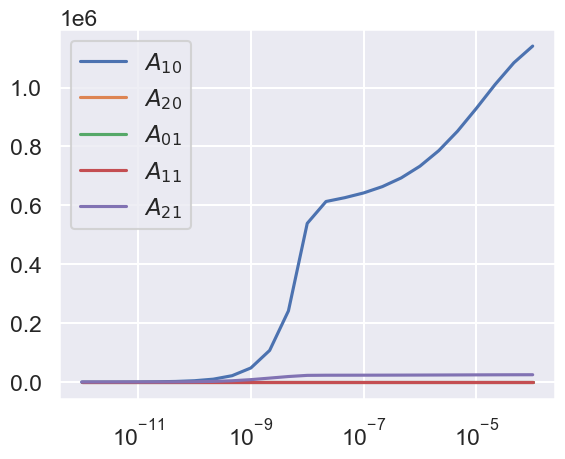

In [436]:
plt.plot(A0s, A10rs, label = r'$A_{10}$')
plt.plot(A0s, A20rs, label = r'$A_{20}$')
plt.plot(A0s, A01rs, label = r'$A_{01}$')
plt.plot(A0s, A11rs, label = r'$A_{11}$')
plt.plot(A0s, A21rs, label = r'$A_{21}$')


plt.xscale('log')
plt.legend(loc='best')
plt.show()

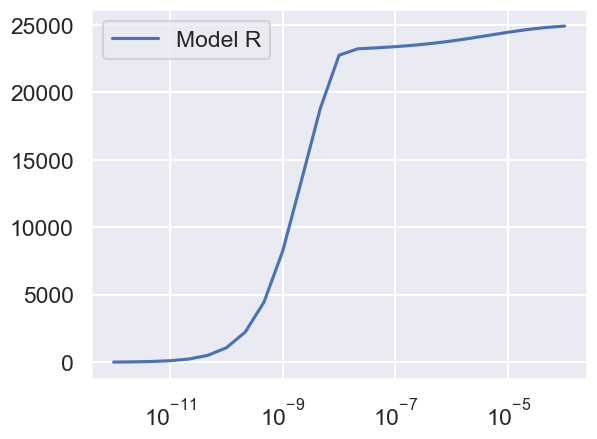

In [437]:
plt.plot(A0s, A11rs + A21rs, label = 'Model R')
plt.xscale('log')
plt.legend(loc='best')
plt.show()

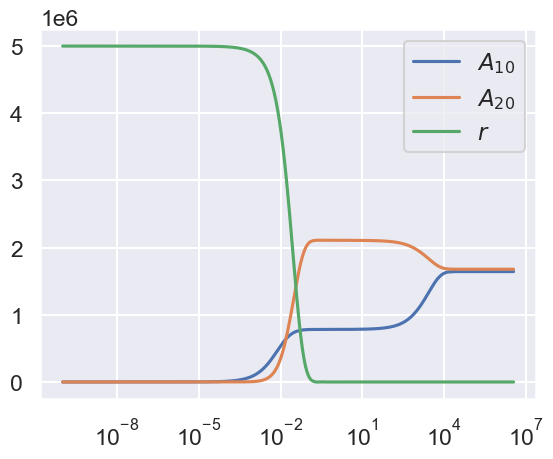

In [454]:
D_t = 1e-14
D_f = 7.4e-14
rtot = 5e6
kon=1e5
rtot_synapse = rtot*tumour_cell_IS_proportion
rtot_fc_synapse = rtot_fc*NK_cell_IS_proportion
k1 = kon/sigma_synapse
k3 = qon/sigma_synapse
k2 = 4*D_t/(tumour_cell_surface_area)
k4 = 4*D_f/(NK_cell_surface_area)
Ainit = 1e-4

z0 = [0, 0]
z = solve_ivp(S_single_cell, tspan, z0, method='BDF', t_eval=t, args=(Ainit, rtot, kon, k2, koff))

A1 = z.y[0]
A2 = z.y[1]

plt.plot(t, A1, label = r'$A_{10}$')
plt.plot(t, A2, label = r'$A_{20}$')
plt.plot(t, rtot- A1 - 2*A2, label= r'$r$')
plt.xscale('log')
plt.legend()
A10_IC = A1[-1]*tumour_cell_IS_proportion
A20_IC = A2[-1]*tumour_cell_IS_proportion
Atot = A10_IC + A20_IC + 1e4
z0 = [A10_IC, A20_IC, 1e4, 0, 0]
z = solve_ivp(S_two_cells, tspan, z0, method='BDF', t_eval=t, args=(k1, k2, k3, k4, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))


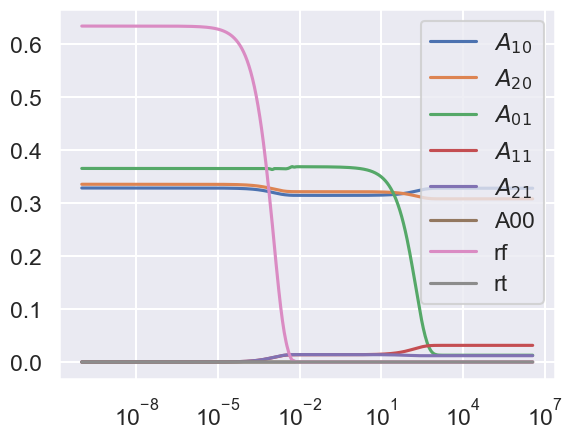

In [455]:

A10 = z.y[0]
A20 = z.y[1]
A01 = z.y[2]
A11 = z.y[3]
A21 = z.y[4]
A00 = (Atot - (A10 +A20 +A01 + A11 +A21))
rt = rtot_synapse - z.y[0] - z.y[3] - 2*(z.y[1] + z.y[4])
rf = rtot_fc_synapse  - z.y[2] - (z.y[3] + z.y[4])

plt.plot(t, A10/rtot_synapse, label = r'$A_{10}$')
plt.plot(t, A20/rtot_synapse, label = r'$A_{20}$')
plt.plot(t, A01/rtot_fc_synapse, label = r'$A_{01}$')
plt.plot(t, A11/rtot_synapse, label = r'$A_{11}$')
plt.plot(t, A21/rtot_synapse, label = r'$A_{21}$')
plt.plot(t, A00/Atot, label='A00')
plt.plot(t, rf/rtot_fc_synapse, label='rf')
plt.plot(t, rt/rtot_synapse, label='rt')

plt.xscale('log')
plt.legend(loc='best')
plt.show()

In [391]:
"""

# solve nondimensional S

alpha1 = k1*rtot_synapse/koff
alpha2 = k2*rtot_synapse/koff
alpha3 = k3*rtot_fc_synapse/koff
alpha4 = k4*rtot_fc_synapse/koff
alpha5 = alpha4
alpha6 = alpha2
alpha7 = alpha2
gamma2 = 2*koff/koff
gamma3 = qoff/koff
gamma4 = gamma3
gamma5 = gamma3 
gamma6 = koff/koff
gamma7 = 2*koff/koff


phi = rtot_synapse/rtot_fc_synapse
t_end = 60*60*1000*(koff)
t = np.geomspace(1e-5, t_end, 500)
tspan = [1e-5, t_end]
A0s = np.geomspace(1e-12, 1e-4, 25)
A10s = np.zeros_like(A0s)
A20s = np.zeros_like(A0s)
A01s = np.zeros_like(A0s)
A11s = np.zeros_like(A0s)
A21s = np.zeros_like(A0s)
print(alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, alpha7, gamma2, gamma3, gamma4, gamma5, gamma6, gamma7, beta, phi)
for i, Ainit in enumerate(A0s):
    print(i)
    z0 = [0, 0]
    z = solve_ivp(S_single_cell, tspan, z0, method='Radau', t_eval=t, args=(Ainit, rtot, kon, k2, koff))

    A1 = z.y[0]
    A2 = z.y[1]
    Atot = A1[-1] + A2[-1]
    beta = Atot/rtot_synapse
    A10_IC = A1[-1]*tumour_cell_IS_proportion/rtot_synapse
    A20_IC = A2[-1]*tumour_cell_IS_proportion/rtot_fc_synapse
    z0 = [A10_IC, A20_IC, 0, 0, 0]
    z = solve_ivp(two_cells_dimensionless, tspan, z0, method='BDF', t_eval=t, args=(alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, alpha7, 
                                                                          gamma2, gamma3, gamma4, gamma5, gamma6, gamma7, beta, phi))
    print(z.message)
    print(z.nfev)
    A10 = z.y[0]
    A20 = z.y[1]
    A01 = z.y[2]
    A11 = z.y[3]
    A21 = z.y[4]

    A10s[i] = A10[-1]
    A20s[i] = A20[-1]
    A01s[i] = A01[-1]
    A11s[i] = A11[-1]
    A21s[i] = A21[-1]

"""

"\n\n# solve nondimensional S\n\nalpha1 = k1*rtot_synapse/koff\nalpha2 = k2*rtot_synapse/koff\nalpha3 = k3*rtot_fc_synapse/koff\nalpha4 = k4*rtot_fc_synapse/koff\nalpha5 = alpha4\nalpha6 = alpha2\nalpha7 = alpha2\ngamma2 = 2*koff/koff\ngamma3 = qoff/koff\ngamma4 = gamma3\ngamma5 = gamma3 \ngamma6 = koff/koff\ngamma7 = 2*koff/koff\n\n\nphi = rtot_synapse/rtot_fc_synapse\nt_end = 60*60*1000*(koff)\nt = np.geomspace(1e-5, t_end, 500)\ntspan = [1e-5, t_end]\nA0s = np.geomspace(1e-12, 1e-4, 25)\nA10s = np.zeros_like(A0s)\nA20s = np.zeros_like(A0s)\nA01s = np.zeros_like(A0s)\nA11s = np.zeros_like(A0s)\nA21s = np.zeros_like(A0s)\nprint(alpha1, alpha2, alpha3, alpha4, alpha5, alpha6, alpha7, gamma2, gamma3, gamma4, gamma5, gamma6, gamma7, beta, phi)\nfor i, Ainit in enumerate(A0s):\n    print(i)\n    z0 = [0, 0]\n    z = solve_ivp(S_single_cell, tspan, z0, method='Radau', t_eval=t, args=(Ainit, rtot, kon, k2, koff))\n\n    A1 = z.y[0]\n    A2 = z.y[1]\n    Atot = A1[-1] + A2[-1]\n    beta = At

In [461]:
A0s = np.geomspace(1e-12, 1e-4, 25)
t_end = 60*60*1000
t = np.geomspace(1e-10, t_end, 1000)
tspan = [1e-10, t_end]
A10ss = np.zeros_like(A0s)
A20ss = np.zeros_like(A0s)
A01ss = np.zeros_like(A0s)
A11ss = np.zeros_like(A0s)
A21ss = np.zeros_like(A0s)

for i, Ainit in enumerate(A0s):
    print(i)
    z0 = [0, 0]
    z = solve_ivp(S_single_cell, tspan, z0, method='BDF', t_eval=t, args=(Ainit, rtot, kon, k2, koff))

    A1 = z.y[0]
    A2 = z.y[1]

    A10_IC = A1[-1]*tumour_cell_IS_proportion
    A20_IC = A2[-1]*tumour_cell_IS_proportion
    Atot = A10_IC + A20_IC + 1e4
    z0 = [A10_IC, A20_IC, 1e4, 0, 0]
    z = solve_ivp(S_two_cells, tspan, z0, method='BDF', t_eval=t, atol = 1e-15, args=(k1, k2, k3, k4, koff, qoff, rtot_synapse, rtot_fc_synapse, Atot))
    print(z.message)
    A10 = z.y[0]
    A20 = z.y[1]
    A01 = z.y[2]
    A11 = z.y[3]
    A21 = z.y[4]

    A10ss[i] = A10[-1]
    A20ss[i] = A20[-1]
    A01ss[i] = A01[-1]
    A11ss[i] = A11[-1]
    A21ss[i] = A21[-1]


0
The solver successfully reached the end of the integration interval.
1
The solver successfully reached the end of the integration interval.
2
The solver successfully reached the end of the integration interval.
3
The solver successfully reached the end of the integration interval.
4
The solver successfully reached the end of the integration interval.
5
The solver successfully reached the end of the integration interval.
6
The solver successfully reached the end of the integration interval.
7
The solver successfully reached the end of the integration interval.
8
The solver successfully reached the end of the integration interval.
9
The solver successfully reached the end of the integration interval.
10
Required step size is less than spacing between numbers.
11
The solver successfully reached the end of the integration interval.
12
The solver successfully reached the end of the integration interval.
13
The solver successfully reached the end of the integration interval.
14
The solver 

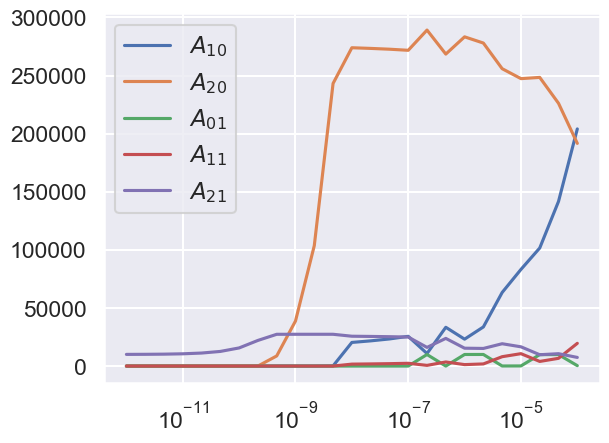

In [460]:

plt.plot(A0s, A10ss, label = r'$A_{10}$')
plt.plot(A0s, A20ss, label = r'$A_{20}$')
plt.plot(A0s, A01ss, label = r'$A_{01}$')
plt.plot(A0s, A11ss, label = r'$A_{11}$')
plt.plot(A0s, A21ss, label = r'$A_{21}$')


plt.xscale('log')
plt.legend(loc='best')
plt.show()


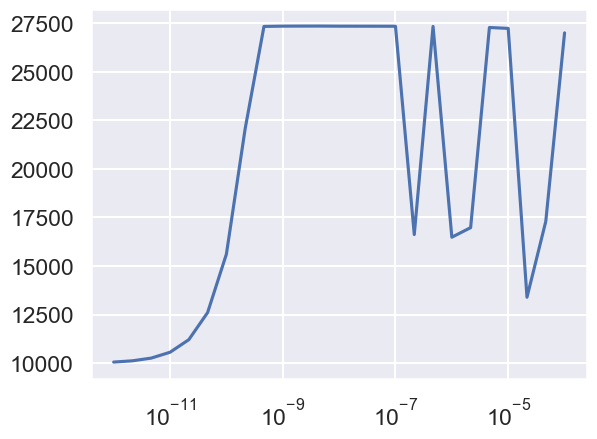

In [458]:
plt.semilogx(A0s, A11ss + A21ss)